<a href="https://colab.research.google.com/github/jimmynewland/colabnotebooks/blob/main/Cep_C_SED_Generator_Active_Version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

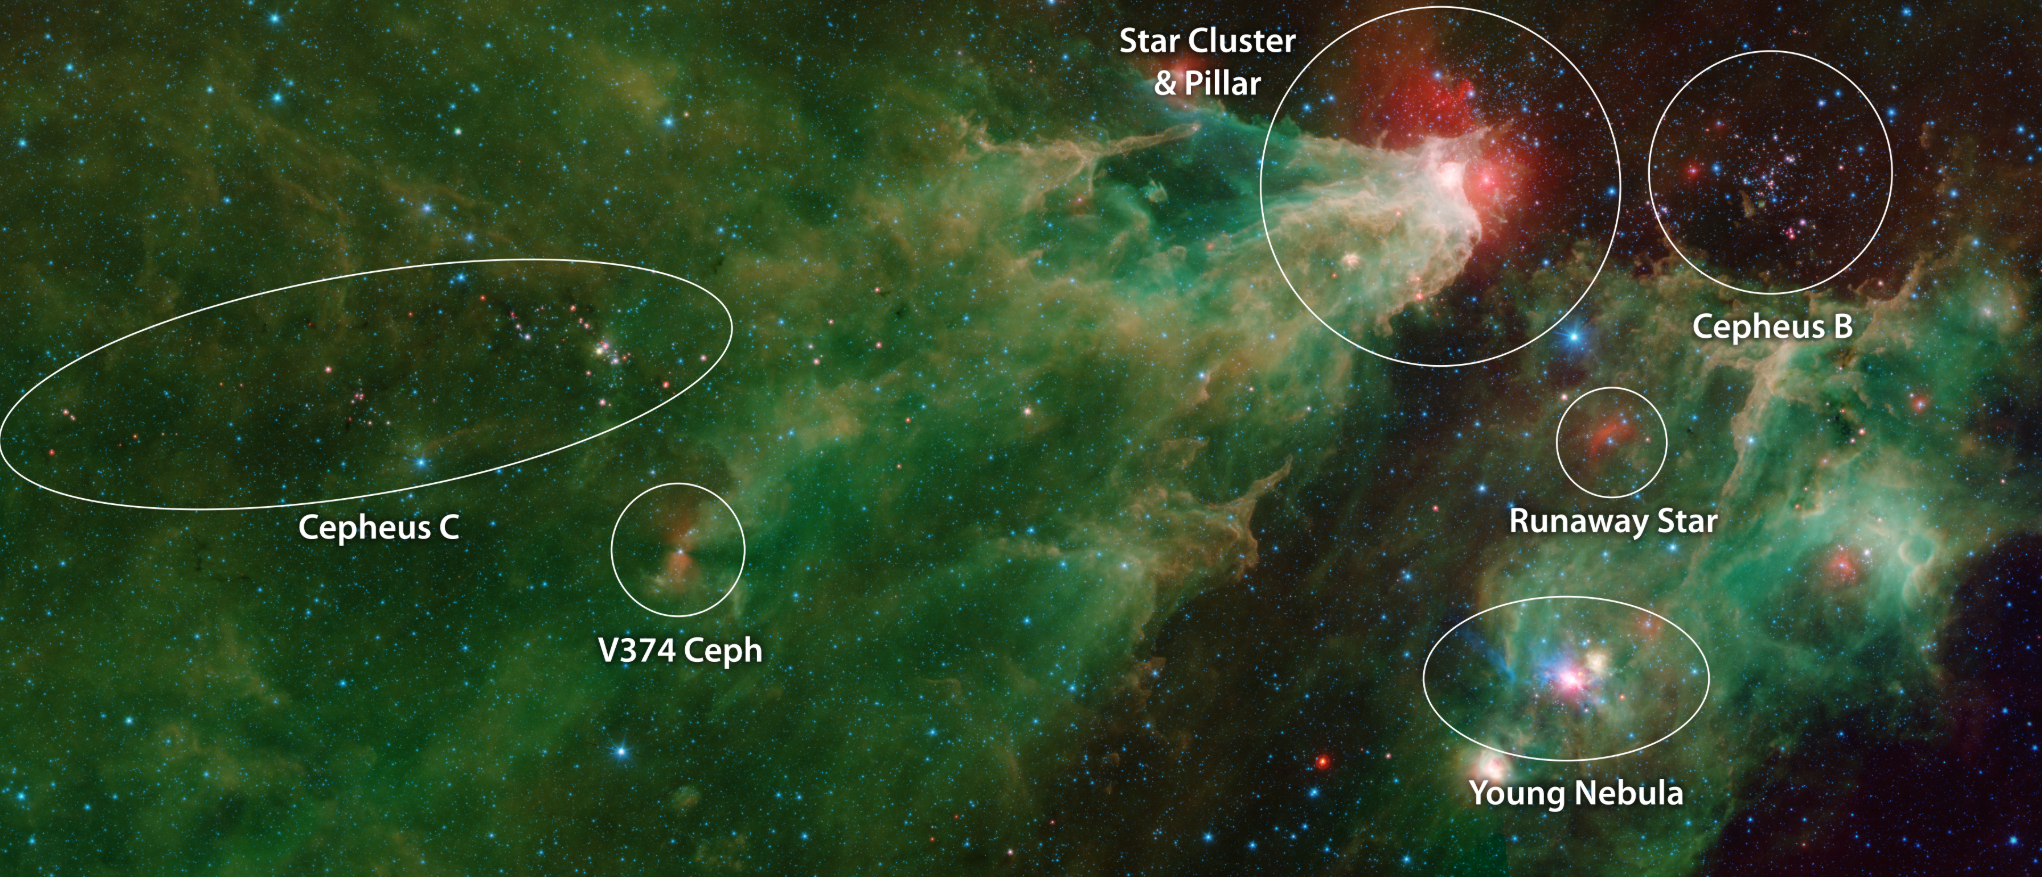

# CEP C (Not Ceph C 🙄) SED generating code Notes:


**General**
- Functions are denoted by capital letters in the title. If you see need to find a function definition, search for the corresponding name in capitalized letters on one of the section headers
- Scroll down to the LOOPY SEDs section to see the main body of the code

---


**To-Do List:**

--> **Short-Term** (errors, do {higher priority} while (productive 🛠️🖥️))
-  Error: Where are the divide by 0 errors coming from?
-  Error: When removing nan from actualFlux, remove the corresponding lambda values (see how the np.nan issue works)
-  Error: Why do some of the SEDs seem to have repeated flux values ( print actualFlux for each SED, or check the google doc for pictures 🖼️ since you can't read )
-  Major edit: Create 2 different slopes (2-8 and 2-24) and tolerance for the difference. Else debris-disk 2️⃣
  - Plot both slopes
  - Add another error calculator to the finalCSV for 2-8 (i.e. show the error between 2-8 and Rebull vs 2-24 and Rebull)
  - Display more information on the plot (best fit slope 2-8 vs 2-24, as well as difference in YSO class if applicable)
  - In the ending code which prints the class divisions, print one for 2-8 vs 2-24
  - Create an average best fit slope to add to CSV, and possibly to plot. Needs to be determined how this should work.
-  New code: generate SED for one target
-  New code: Add r or r^2 for the lineS (PLURAL) to the final CSV
-  Error: Catch exceptions, especially in the Rayleigh-Jeans function during the logarithm calculations

--> **Long-Term** (do {lower priority } while (🧠 -> 🙃))
- #comments #️⃣ (delete personal / stupid , add useful)
- Finish the block titles 🧱
- Replace the image links in the finalArray CSV with links to Google Drive images so that it updates on each run of the code 📎
- 🔎Investigate matplot modes (🌌Dark mode is a bit 🧐)
- Rewrite the limit function to be applicable to other files (Rebull IDL code to see how her limits / CSV generator works)
- Fix 🖼️ sizing (see https://jimmynewland.com/astronomy/ipac/cepc/cepcsed.html, why aren't all the SEDs the same size)
- See what else needs to be rewritten to be more user friendly 🫂 / universally applicable

--> **Dr. Newland said...**
- Include longer wavelength data (Herschel and SCUBA)
- Add color-color plots to characterize the population
- Add IRAC 3 and IRAC 4

--> **Questions**
- Should the lower wavelength best fit line plot even if there are less than 4 points?

Note to self: Delete the emojis before Dr. Newland ❓ it. (Disregard this if you *are* Dr. Newland, I haven't 😴 in... insomnia? Is that a number? What's wrong with me? Anyways, writing code and listening to music and talking to myself through text and pictures helps... maybe 🤷)


# Getting Set Up


In [ ]:
#@title Download Libraries
  # Remember you can use CTRL+m+o or Command+m+o to hide this output after you run it
!pip install -U astroquery
!pip install -U pyvo

In [ ]:
#@title Import Libraries and Google Drive
# AstroPy.Table  makes it easy to handle data in a structured way
from astropy.table import Table

# Imports the IRSA class from the Astroquery library, to easily access and
#   retrieve astronomical data from the Infrared Science Archive (IRSA)
from astroquery.ipac.irsa import Irsa

# PyVO is a popular library to interact with Virtual Observatory (VO) tools
import pyvo as vo

# This line of code brings in the SIA (Simple Image Access) module from the
#   pyvo.dal package of the PyVO library. The SIA module is used to get pictures
#   of stars and other space objects from different space data sources.
#from pyvo.dal import sia

# Imports the plotting library Matplotlib and allows the
#   shorthand "plt" to create graphs and charts
import matplotlib.pyplot as plt

# Imports the NumPy library and allows use the shorthand "np" to
#   perform powerful math operations and work with large arrays of numbers
import numpy as np

# Imports the pandas library and allows the shorthand "pd" to
#   work with data structures for organizing and analyzing data easily
import pandas as pd

# Imports the statistics module from the SciPy library, providing users
#   with tools and functions to do a linear regression
from scipy import stats

# LINEAR REGRESSION?! Perhaps...
from sklearn import linear_model

# Connecting our shared Google Drive to this notebook and installing libraries
# needed for interfacing with the Drive
from google.colab import drive
drive.mount('/content/drive')

from googleapiclient.http import MediaFileUpload
from google.colab import files
import os

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#@title Define Global Arrays & FLUX DENSITY
# This code will read in a CSV file (it's similar to a spreadsheet but simpler)
#  that will make the data easy to work with in Python. Pandas is a library
#  that helps organize the data into rows and columns.

# Lambda and zeropoint values for each
bandpasses = pd.read_csv('https://jimmynewland.com/astronomy/ipac/binap_bandpasses.csv')

# These are the column labels we already decided we want to use:
maglabels = [ 'pangmag',   'panrmag',  'panimag', 'panzmag',  'panymag',
             'iphasrmag',  'iphasimag', 'iphashamag',
              'gaia3_gmag', 'gaia3_bpmag', 'gaia3_rpmag',
              'bestjmag', 'besthmag', 'bestkmag',
              'irac1mag', 'irac2mag',
              'wise1mag', 'wise2mag', 'wise3mag','wise4mag',
]

# These will be used as labels on the SED plot later
catalog = ['PanSTARRS g','PanSTARRS r','PanSTARRS i','PanSTARRS z','PanSTARRS y',
          'IPHAS r','IPHAS i','IPHAS Ha',
           'Gaia G','Gaia Bp','Gaia Rp',
           '2MASS J','2MASS H','2MASS K',
           'IRAC-1','IRAC-2',
           'WISE-1','WISE-2','WISE-3','WISE-4',
           ]

# These are colors on the plot corresponding to each label in the catalog
color =   ['cyan', 'cyan', 'cyan', 'cyan', 'cyan',
           'orange', 'orange', 'orange',
           'green','green','green',
           'black','black','black',
           'black','black',
           'black','black','black','black',
]

# These will be different shapes on the plot
marker = ['D', 'D', 'D', 'D','D',
          'h','h','h',
          's','s','s',
          '^','^','^',
          'o','o',
          '*','*','*','*',
          ]

# This function takes in the zeropoint flux density in a specific unit along
#   with its magnitude and outputs its flux density in the same units

def flux_density(zeropoint, mag):
  return zeropoint*10**(-mag/2.5)

In [ ]:
#@title Set Up the Project Library in Google Drive
# Set up the project: read the file and create folders

# Converts the CSV to a pandas data frame, then a table
df = pd.read_csv('/content/drive/Shareddrives/Cep C Project/JN_Working_Catalog_with_Gaia_for_inspection.csv')

# Honestly forgot why I wrote it, but too worried to mess with my trainwreck code.
# It might have something to do with the finalArray csv formatting but who knows at this point
df['designation'] = df['designation'].astype(str)
df['designation'] = df['designation'].str.replace(' ', '')
t = Table.from_pandas(df)

# Creating an array which will be used later to compare our results to Dr. Rebull's results
finalArray = []
headerArray = ['Designation',
               'Right Ascension (Gaia)',
               'Right Ascension (original)',
               'Declination (Gaia)',
               'Declination (original)',
               'Best Fit Slope',
               'YSO Class',
               'Best Fit Slope - Lower',
               'YSO Class - Lower',
               'SED SLOPE (original)',
               'SED CLASS (original)',
               'Percent Error',
               'Absolute Error',
               'Link to Image']
finalArray.append(headerArray)

# Creating a subfolder in our project folder to store the SEDs as images
root_dir = "/content/drive/Shareddrives/Cep C Project"
project_folder = "/Plot Images"
os.chdir(root_dir + project_folder)

# SED generating functions

In [ ]:
#@title LIMIT - Remove limits from data

# Due to the way limits are notated in our file,
# the limit indicators in one column indicate that the magnitude in the adjacent column is a limit
# This is a dictionary connecting the limit column to the corresponding magnitude column
limits = {'lim_2'  : 'bestjmag',
          'lim_2a'  : 'besthmag',
          'lim_2b' : 'bestkmag',
          'lim_2c' : 'irac1mag',
          'lim_2d' : 'irac2mag',
          'lim_2e' : 'I3mag',
          'lim_2f' : 'I4mag',
          'lim_2g' : 'wise1mag',
          'lim_2h' : 'wise2mag',
          'lim_2i' : 'wise3mag',
          'lim_2j' : 'wise4mag',
          'lim_2k' : 'S450flux'}

# This limit function checks the limit column to see if a limit is indicated.
# If so, it sets the corresponding magnitude to 0 so that it is not plotted later

def limit(target):
    for column in limits:
      if (target[column].astype(str) == ">"):
        target[limits[column]] = 0

In [ ]:
#@title BUILD MAGS - DataFrame of Magnitudes and Their Labels

def buildMags(target):
  # Fetches the data at each magnitude
  for label in maglabels:
    maglist.append(target[label])

  # Creates a pandas data frame with the magnitude at this wavelength and corresponding magnitude label
  mags = pd.DataFrame(data = maglist, index=maglabels)
  return mags

In [ ]:
#@title BUILD SED - Create flux array and handle zeropoint / bandpass

def buildSed(target, mags):
  sed = []
  for label in maglabels:
    # Cinnajour's explanation: Get the bandpasses for each magnitude.
    # Use them somehow (check the bandpass file before coming back to comment)

    # match the names of the label (if anything isn't spelled right, this will be bad!)
    # iloc means get the first matching row
    # float converts that value a "real number" (not an integer)
    l = float(bandpasses.loc[bandpasses['band'] == label, 'lambda'].iloc[0])
    zp = float(bandpasses.loc[bandpasses['band'] == label, 'zeropoint'].iloc[0])

    # This is the value of the actual magnitude for that label
    mag = mags[0][label]

    # Now we do the conversion to flux density
    flux = flux_density(zp, mag) # Step 3 of Rebull 2023 SED Worksheet

    # Save the value to our SED table
    sed.append(flux)
  return sed

In [ ]:
#@title JUST WAVELENGTHS - Create a table of Wavelengths and Flux Densities
def justWavelengths(mags):
  justWavelengths = []

  for label, cat, displayColor, markerType, flux in zip(maglabels, catalog, color, marker, sed):
      # Get the wavelength value
      lambda_value = float(bandpasses.loc[bandpasses['band'] == label, 'lambda'].iloc[0])

      # Get the magnitude value for that label
      mag = mags[0][label]

      # Save the values as a dictionary to our list
      justWavelengths.append({'Wavelength': lambda_value})
  return justWavelengths

In [ ]:
#@title UNIT CONVERSION - Convert from Janksy to erg/s/cm**2
def unitConversion(sed, justWavelengths):
# The section of code converts from Janskys (Jy) to erg/s/cm**2 per Rebull 2023 SED
  for j in range(len(maglabels)):

    # Part A:  1 Jansksy = 10^-23 ergs/s/cm^2/Hz (cgs)
    sed[j] = sed[j] * 10**-23

    # Part B: - convert F-nu to F-lambda
    # Multiply by c/lambda^2 - c = 3*10^10 cm/s & lambda in μm
    sed[j] = sed[j] * 3*10**10 / (justWavelengths.Wavelength[j]**2)

    # Part C
    # calcuate lambda * F-lambda and convert from μm to cm. 1 micron = 10^-4 cm
    sed[j] = justWavelengths.Wavelength[j] * sed[j]  / 10**-4
  return sed

In [ ]:
#@title WAVELENGTHS
def wavelengths(mags):
  # Initialize an empty list to store the data
  wavelengthsForUs = []

  for label, cat, displayColor, markerType, flux in zip(maglabels, catalog, color, marker, sed):
      # Get the wavelength value
      lambda_value = float(bandpasses.loc[bandpasses['band'] == label, 'lambda'].iloc[0])

      # Get the magnitude value for that label
      mag = mags[0][label]

      # Save the values as a dictionary to our list
      wavelengthsForUs.append({'Catalog': cat,'Label': label, 'Wavelength': lambda_value, 'Magnitude': mag, 'Color': displayColor, 'Marker':markerType, 'Flux':flux})
  return wavelengthsForUs

In [ ]:
#@title RAYLEIGH JEANS
# What brand of pants do astronomers wear? Rayleigh jeans! (JN I love this)
def RayleighJeans(mags):

      # Look up what we need to calculate y-coordinate for point 1:
      ourTarget_kband = mags[0]['bestkmag']
      zeropoint2_2 = float(bandpasses.loc[bandpasses['band']=='bestkmag', 'zeropoint'].iloc[0])
      # Convert to energy density
      # The constant 3*10**-9 converts from Jy to erg/s/cm**2
      energyDensity2_2 = np.log10(flux_density(zeropoint2_2, ourTarget_kband)*3*10**-9/2.6) #lambda is 2.6 μm
      # We just looked this up on the Internet
      # It's the zeropoint for 24 μm from the MIPS1 or M1 Spitzer channel
      # https://coolwiki.ipac.caltech.edu/index.php/Central_wavelengths_and_zero_points
      zeropoint_24 = 7.14 # Jy
      energyDensity24= np.log10(flux_density(zeropoint_24, ourTarget_kband)*3*10**-9/24)



      # Set up the x (lambda) values so we can plot them later:
      RJ_lambda = np.array([])
      RJ_lambda = np.append(np.log10(2.2), RJ_lambda)
      RJ_lambda = np.append(np.log10(24), RJ_lambda)

      # Set up the y (energy density) values to plot as well:
      RJ_energyDensity = np.array([])
      RJ_energyDensity = np.append(energyDensity2_2, RJ_energyDensity)
      RJ_energyDensity = np.append(energyDensity24, RJ_energyDensity)
      return RJ_lambda, RJ_energyDensity

In [ ]:
#@title FILTER POINTS
def filterPoints(wavelength_table):
  # Create a blank lambda (x-coordinate) array to add values to
  #This array while store wavelengths which are from 2 - 8
  actualLambdaLow = np.array([])
  #This stores all wavelengths 2 - 24
  actualLambda = np.array([])


  # Create a blank energy density (y-coordinate) array to add values to
  #This stores all fluxes corresponding to 2 - 8 um
  actualFluxLow = np.array([])
  # This stores all fluxes corresponding to 2 - 24 um
  actualFlux = np.array([])

  for k in range(len(wavelength_table)):
    data = wavelength_table.iloc[k]
    if data['Wavelength'] != None and data['Flux'] != None:
      currentWavelength = data['Wavelength']
      currentFlux = data['Flux']
    # If our wavelength 2 μm or longer, add the logarithms of those
    #   values to our list to look at in the next part
    if currentWavelength >= 2 and currentWavelength <= 24:
      actualLambda = np.append(np.log10(currentWavelength), actualLambda)
      actualFlux = np.append(np.log10(currentFlux), actualFlux)
    if currentWavelength >= 2 and currentWavelength <= 8:
      actualLambdaLow = np.append(np.log10(currentWavelength), actualLambdaLow)
      actualFluxLow = np.append(np.log10(currentFlux), actualFluxLow)
  #Removing nan arrays - this code will cause some errors when actualFlux has only a few nan values because the corresponding lambda values are not removed
  actualFlux = actualFlux[~np.isnan(actualFlux)]
  actualFluxLow = actualFluxLow[~np.isnan(actualFluxLow)]

  #THIS IS REALLY BAD I'M JUST PLAYING WITH SOMETHING. DON'T LEAVE IT IN HERE...
  # unless you really can't figure out the original error
  # ("if it works it works" != "can't figure it out")
#  count = 0
#  for i in range(actualFlux.size - 1):
#    if (actualFlux[i] == actualFlux[i+1]):
#      count += 1
#
#  print("Count = ", count, "and array size = ", actualFlux.size)
#  if (count == (actualFlux.size -2) and count > 1):
#    actualFlux = np.array([])
#    return actualLambda, actualFlux

  return actualLambda, actualFlux, actualLambdaLow, actualFluxLow

In [ ]:
#@title YSO CLASS - Use Best Fit Line Slope to classify the YSO

def YSO_Class(bestFitSlope):
  ysoClass = ""
  # If the slope is very positive, it is class I
  if (bestFitSlope >= 0.3):
    ysoClass = "I"
  # If the slope is not super positive but it isn't very negative, it is class flat (around 0 slope)
  elif (bestFitSlope < 0.3 and bestFitSlope >= -0.3):
    ysoClass = "Flat"
  # If the slope is somewhat negative, it is class II
  elif (bestFitSlope < -0.3 and bestFitSlope >= -1.6):
    ysoClass = "II"
  # If the slope is practically the R-J line, it is class III
  elif (bestFitSlope < -1.6):
    ysoClass = "III"
  return ysoClass

In [ ]:
#@title ADD TO FINAL ARRAY - Adds a row of data for output CSV

def addToFinalArray(target, bestFitSlope, ysoClass, bestFitSlope_Low, ysoClass_Low):
  #Calculate Percent Error between our Best Fit Slope and Dr. Rebull's Best Fit Slope
  if ((float(target['sedslope'])) != 0):
    error = (bestFitSlope - float(target['sedslope'])) / (float(target['sedslope']))
  else:
    error = np.nan

  finalArray.append([
        str(target['designation']),                                                    # Designation
        float(target['ra Gaia']),                                                      # Right Ascension (Gaia)
        float(target['ra_deg Catalog']),                                               # Right Ascension (original)
        float(target['dec Gaia']),                                                     # Declination (Gaia)
        float(target['dec_deg Catalog']),                                              # Declination (original)
        float(bestFitSlope),                                                           # Best Fit Slope
        str(ysoClass),                                                                 # YSO Class
        float(bestFitSlope_Low),                                                       # Best Fit Slope (lower)
        str(ysoClass_Low),                                                             # YSO Class (lower)
        float(target['sedslope']),                                                     # SED SLOPE (original)
        str(target['sedclass']),                                                       # SED CLASS (original)
        (error * 100),                                                                 # Percent Error
        abs(bestFitSlope - float(target['sedslope'])),                                 # Absolute Error
        'https://jimmynewland.com/astronomy/ipac/cepc/'+target['designation']+'.png']) # Link to Image

In [ ]:
#@title PLOT IMAGE - Sets up Matplot to display the SED
def plotImage(RJ_lambda, RJ_energyDensity, bestFitSlope, actualLambda, bestFitIntercept, ysoClass, actualLambdaLow, bestFitSlope_Low, bestFitIntercept_Low):
  fig, ax = plt.subplots()


  plt.title(str(target['ra Gaia']) + ' + ' + str(target['dec Gaia']) + ' SED')
  plt.xlabel('Wavelength $[log({\mu}m)]$')
  plt.ylabel('Energy Density [$log(erg/s/cm^2)$]')
  plt.style.use('dark_background')

  # Plot the Rayleigh-Jeans line
  plt.plot(RJ_lambda, RJ_energyDensity, linestyle='dashed', c='g', label='Rayleigh-Jeans Line')

  # Plot the best-fit line for the Rayleigh-Jeans line to show IR excess
  #    This is just y = mx + b

  #IMPORTANT: NEEDS TO BE FIXED SO THAT BEST FIT DOES NOT SHOW UNLESS THERE IS ALSO A RAYLEIGH JEANS LINE!!!!
  plt.plot(actualLambda, bestFitSlope*actualLambda + bestFitIntercept, linestyle='dashed', c='r', label='Best Fit Line')

  #This is the best fit line for only 2 - 8 um
  plt.plot(actualLambdaLow, bestFitSlope_Low*actualLambdaLow + bestFitIntercept_Low, linestyle='dashed', c='b', label='Best Fit Line - Lower')

  #Add the YSO Class onto the plot image
  plt.figtext(x = 0.5, y = 1,s=" Class " + ysoClass)

  #Add the slopes onto the plot image
  plt.figtext(x = 0.4, y = -0.1,s="Best Fit Slope: " + str(bestFitSlope))
  plt.figtext(x = 0.4, y = -0.15,s="Rebull Slope: " + str(target['sedslope']))
  # Plot all the points we put together in that wavelength table we made
  # The variable d is just referring to each row of the table, and we're getting
  #    specific information from each row to plot
  for l in range(len(wavelength_table)):
    d = wavelength_table.iloc[l]
    plt.scatter(x=np.log10(d['Wavelength']), y=np.log10(d['Flux']), marker=d['Marker'] ,label=d['Catalog'], s=10)

  plt.legend(bbox_to_anchor=(1,1), loc="upper left")

  plt.savefig(str(target['designation']) + '.png',bbox_inches = 'tight', pad_inches = 0.5)
  if os.path.isfile("/content/drive/MyDrive/" + str(target['designation']) + '.png') == True:
    os.remove("/content/drive/MyDrive/" + str(target['designation']) + '.png')
    !touch str(target['designation']) + '.png'

  plt.show()

# Individual SEDs - All alone

In [ ]:
#target = input()

# Loopy SEDs 🤪 start here!
Get it? Loopy? Because I keep messing them up *and* they're generated with a loop! And because it's 1:11 A.M. so I'm a little loopy...


/usr/local/lib/python3.11/dist-packages/pandas/core/internals/construction.py:578: UserWarning: Warning: converting a masked element to nan.
  values = np.array([convert(v) for v in values])


[np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(0.00023370007392222903), np.float64(0.0012040897232560603), np.float64(0.0008421692352305673), np.float64(0.0008706468221325628), np.float64(0.00016599605992982056), np.float64(0.0023701924231720878), np.float64(0.015649062211738552), np.float64(0.035505853486339244), np.float64(0.051042325782773505), np.float64(0.04704914538758264), np.float64(0.08841950456195675), np.float64(0.060078181455006895), np.float64(0.08298467160241257), np.float64(0.19263284300504657), np.float64(0.4681532700104354)]


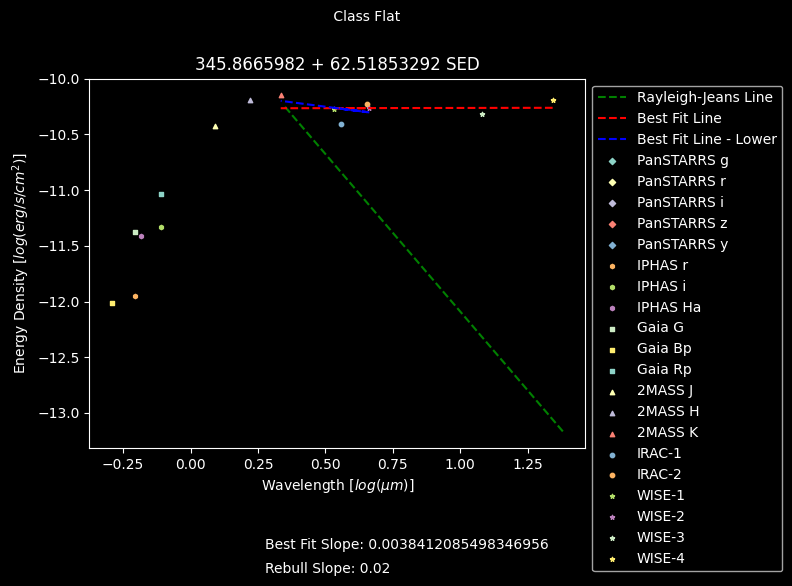

[np.float64(3.281151239085673e-05), np.float64(0.00012360221368043318), np.float64(0.00035977107919056355), np.float64(0.0005970713726993408), np.float64(0.000794376245656084), np.float64(8.407344621936939e-05), np.float64(0.0003285934103273271), np.float64(0.00019471498361457018), np.float64(0.0001652266201842126), np.float64(5.669643864440376e-05), np.float64(0.0003998534112771695), np.float64(0.0013755878051405505), np.float64(0.0015642276436357869), np.float64(0.0014319585771028266), masked, np.float64(0.0004814465479699799), masked, masked, masked, masked]


<ipython-input-32-c23632ac994f>:34: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(x=np.log10(d['Wavelength']), y=np.log10(d['Flux']), marker=d['Marker'] ,label=d['Catalog'], s=10)
<ipython-input-32-c23632ac994f>:34: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.scatter(x=np.log10(d['Wavelength']), y=np.log10(d['Flux']), marker=d['Marker'] ,label=d['Catalog'], s=10)


In [ ]:
#@title Main body of the code which generates the SED images
# looping over every element in the dataframe
for i in range (len(t)):
    #selecting the individual data point and
    target = t[i]
    maglist = []

    mags = buildMags(target)
    #Calling the limit function
    limit(target)

    sed = buildSed(target, mags)
    print(sed)

    # Create a pandas DataFrame from the list of dictionaries
    justWavelengths_table = pd.DataFrame(justWavelengths(mags))

    sed = unitConversion(sed, justWavelengths_table)

    # Create a pandas DataFrame from the list of dictionaries
    wavelength_table = pd.DataFrame(wavelengths(mags))

    # Set up the plot values
    RJ_lambda , RJ_energyDensity = RayleighJeans(mags)

    actualLambda , actualFlux, actualLambdaLow, actualFluxLow = filterPoints(wavelength_table)

    #These lines are useful for testing nan arrays
    #print(str(target['designation']))
    #print("Actual Lambda", actualLambda)
    #print("Actual Flux", actualFlux)

    if (actualFlux.size > 3):
    # Get coefficients of our linear fit log10(lambda) vs log10(flux)
    #   It's giving us r values, p values, and a standard error, but we don't
    #   specifically care about that - we just want the slope and y-intercept
    # reg = linear_model.Ridge(alpha=.1) #What alpha should I use? What is alpha in this context??
    # actualLambda = actualLambda.reshape(-1,1)
    # reg.fit(actualLambda, actualFlux)
    # bestFitSlope = reg.coef_
    # bestFitIntercept = reg.intercept_
      if (actualFluxLow.size >= 2):
        bestFitSlope_Low, bestFitIntercept_Low, r_value_Low, p_value_Low, std_err_Low = stats.linregress(actualLambdaLow, actualFluxLow)
      else:
        bestFitSlope_Low = 0
        bestFitIntercept_Low = 0
      bestFitSlope, bestFitIntercept, r_value, p_value, std_err = stats.linregress(actualLambda, actualFlux)

      #Determine what class the YSO is based on RJ Slope
      ysoClass_Low = YSO_Class(bestFitSlope_Low)
      ysoClass = YSO_Class(bestFitSlope)
      addToFinalArray(target, bestFitSlope, ysoClass, bestFitSlope_Low, ysoClass_Low)

      plotImage(RJ_lambda, RJ_energyDensity, bestFitSlope, actualLambda, bestFitIntercept, ysoClass, actualLambdaLow, bestFitSlope_Low, bestFitIntercept_Low)
    else:
      addToFinalArray(target, np.nan, "Review: < 4 pts", np.nan, "Review: < 4 pts")

In [ ]:
#@title Creating final CSV and class breakdown
classI, classFlat, classII, classIII, numOutRangeous = 0, 0, 0, 0, 0 # get it? outRANGEous instead of outrageous - that is funny.... :D (JN yes)
for i in range(len(finalArray)):
    if (finalArray[i][6] == "I"):
      classI += 1
    elif (finalArray[i][6] == "Flat"):
      classFlat += 1
    elif (finalArray[i][6] == "II"):
      classII += 1
    elif (finalArray[i][6] == "III"):
      classIII += 1
finalArray = np.array(finalArray,dtype = object)
os.chdir("/content/drive/Shareddrives/Cep C Project/Comparing Results")
np.savetxt("Comparing-Results.csv", finalArray, delimiter=",", fmt='%s')
print("Class I: ", classI, "\nClass II: ", classII, "\nClass III: ", classIII, "\nClass Flat: ", classFlat)